# Whotracks.me April Update

This month we have a big update to the site. We have restructured the data we publish to make it easier to use, increased the number of entries we publish, and we have laid the groundwork for internationalised versions of WhoTracks.Me - that means you can see how tracking differs between different countries.

Thanks to integration with Ghostery 8 we collected significantly more tracker data this month, covering 360 million page loads. This is spread over countries across the world, with Germany and the USA the most represented.

In [1]:
%matplotlib inline
# imports and theme setup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set('talk')
sns.set_style('whitegrid')

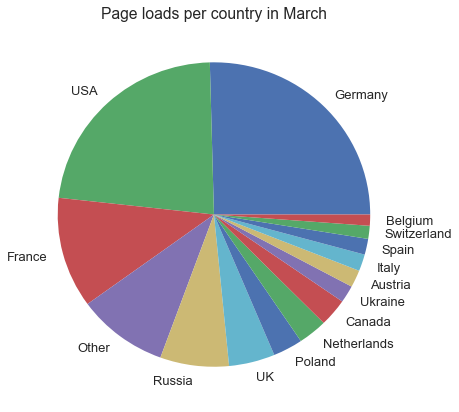

In [2]:
countries = ['Germany', 'USA', 'France', 'Other', 'Russia', 'UK', 'Poland', 'Netherlands', 'Canada', 'Ukraine', 'Austria', 'Italy', 'Spain', 'Switzerland', 'Belgium']
page_loads = [87124064, 78216572, 40282874, 32326828, 24384449, 16317893, 10554555, 10291928, 10054367,
 6268086, 6261035, 6094486, 5753209, 4732324, 4048089]
pl = pd.Series(page_loads, index=countries)
ax = pl.plot.pie(title='Page loads per country in March', figsize=(7, 7))
ax.set_ylabel('')
plt.savefig('../static/img/blog/update_apr18/page_loads_per_country.svg')

This volume of data will also enable us to publish separate rankings for individual countries, something we plan to add later this month.

## Data restructure

We have updated the struture of data which we publish in our [respository](https://github.com/cliqz-oss/whotracks.me/) to make it both easier to use and more scalable as we add more data. We now publish CSV files each month for each of the following:

 * `domains.csv`: Top third-party domains seen tracking.
 * `trackers.csv`: Top trackers - this combines domains known be operated by the same tracker.
 * `companies.csv`: Top companies - aggregates the stats for trackers owned by the same company.
 * `sites.csv`: Stats for number of trackers seen on popular websites.
 * `site_trackers.csv`: Stats for each tracker on each site.

These files can then be loaded with popular data-analysis tools such as [Pandas](https://pandas.pydata.org/). We have also rewritten the code to render the site to take advantage of Pandas. We expose the dataframes via the `DataSource` class which loads data from all CSV files:

In [3]:
from whotracksme.data.loader import DataSource
data = DataSource()
len(data.trackers.df)

data available for months: ['2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03']


7928

We have also updated the criteria by which we include trackers and sites on the main site. We now 'rollover' entries, so once they have been included once, we will keep publishing data (until they completely dissappear from the data). This has the effect of naturally growing the number of trackers and sites we publish. We currently have data on 838 trackers and 748 websites published:

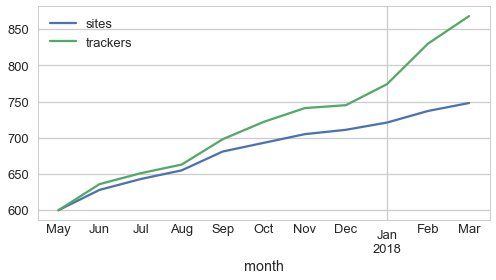

In [4]:
pd.DataFrame({
    'trackers': data.trackers.df.groupby('month').count()['tracker'], 
    'sites': data.sites.df.groupby('month').count()['site']
}).plot(figsize=(7, 4))
plt.tight_layout()
plt.savefig('../static/img/blog/update_apr18/data_growth.svg')

The per site trend for average number of trackers continues a slightly downward trend, but the average is still above 9. There are several possible reasons for this, it is not necessarily that sites are using fewer trackers. The proportion of data from Ghostery users continues to increase, and these users will disproportionately block many trackers. This has an effect on the average number of trackers, because it prevents the blocked trackers from loading others. The data shows also that the average indcidence of blocking for trackers increased to 25% in March, up from 20% in February. 

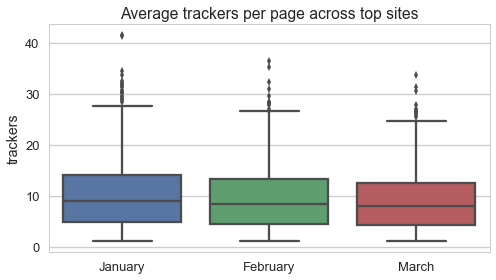

In [5]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots( figsize=(7, 4))
sns.boxplot(data=data.sites.df[data.sites.df.month >= '2018-01'], x='month', y='trackers', ax=ax)
months = ['January', 'February', 'March']
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{months[pos]}'))
ax.set_title('Average trackers per page across top sites')
plt.suptitle('')
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('../static/img/blog/update_apr18/site_trackers_box.svg')

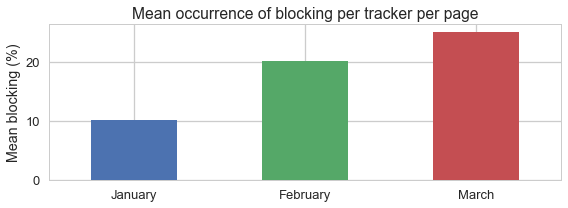

In [6]:
ax = (data.trackers.df[data.trackers.df.month >= '2018-01']\
      .groupby('month')['has_blocking'].mean() * 100)\
      .plot.bar(figsize=(8, 3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{months[pos]}'))
ax.set_ylabel('Mean blocking (%)')
ax.set_xlabel('')
ax.set_title('Mean occurrence of blocking per tracker per page')
plt.tight_layout()
plt.savefig('../static/img/blog/update_apr18/blocking_trend.svg')

As in previous months, we look at sites' changing the trackers. [fewo-direct.de](../websites/fewo-direkt.de.html), [brigitte.de](../websites/brigitte.de.html) and [gutefrage.net](../websites/gutefrage.net.html) all had 5 fewer trackers on average per page this month. However, each of these still has over 50 trackers with some kind of presence, showing that this is more likely a side-effect of increased blocking than an active effort to reduce tracking on their sites. [klingel.de](../websites/klingel.de.html) and [informationvine.com](../websites/informationvine.com.html) see the largest increase in tracking of the sites we currently monitor.

In [7]:
mar_trackers = data.sites.get_snapshot('2018-03').set_index('site')['trackers']
feb_trackers = data.sites.get_snapshot('2018-02').set_index('site')['trackers']
site_diffs = pd.DataFrame({
    'trackers': mar_trackers,
    'change': (mar_trackers - feb_trackers)
})
site_diffs[(site_diffs.change > 5) | (site_diffs.change < -5.5)].sort_values('change')

,change,trackers
fewo-direkt.de,-6.592248,16.006912
brigitte.de,-5.766651,19.540947
gutefrage.net,-5.622986,12.977272
klingel.de,5.265597,26.706119
informationvine.com,6.399617,18.334590


A side-effect of the filtering we added in this new data pipeline is that the site reach for top trackers has increased. In the previous analysis a long-tail of very rarely visited sites reduced effective site reach. With this factor reduced, we get a real sense of the coverage of the largest trackers, with Google Analytics reaching 85% of popular sites, and Facebook almost 60%.

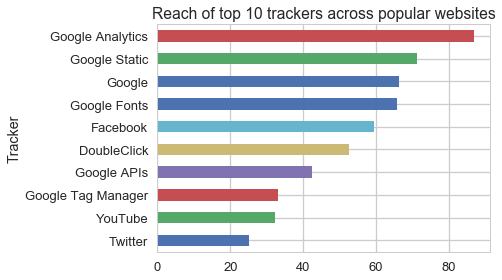

In [8]:
df = data.trackers.get_snapshot().copy()
# add a column with full tracker name
df['Tracker'] = pd.Series(
    [data.app_info.get(tracker, {}).get('name', tracker)
    for tracker in df.tracker], index=df.index)
(df.set_index('Tracker')\
    .sort_values('site_reach', ascending=False)[:10]\
    .iloc[::-1]\
    .site_reach * 100).plot(kind='barh', figsize=(7,4), title='Reach of top 10 trackers across popular websites')
ax.set_xlabel('Site reach %')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('../static/img/blog/update_apr18/top10_site_reach.svg')

If you want to delve deeper into our data, it is available on the [Whotracks.me Github Repository](https://github.com/cliqz-oss/whotracks.me/tree/master/whotracksme/data), and as a [pip package](https://pypi.python.org/pypi/whotracksme/).